In [9]:
#### Importing Libraries ####

import numpy as np
import tqdm as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
#### Functions ####

def p_a_public_belief(a,obs_dist,utility,obs,A,P,public_belief):
    flag = True
    obs_prob = np.diag(obs_dist[:,obs])  
    for a_ in range(A):
        flag = flag and utility[:,a].T@obs_prob@P.T@public_belief >= utility[:,a_].T@obs_prob@P.T@public_belief
    return flag

def T(public_belief,a,X,O,obs_dist,P,A,utility):
    R_a_pi = np.identity(X)
    for x in range(X):
        for o in range(O):
            R_a_pi[x,x] += p_a_public_belief(a,obs_dist,utility,o,A,P,public_belief) * obs_dist[x,o]
    return R_a_pi@P.T@public_belief

### perturbed identity matrix
def perturbed_identity(X,epsilon):
    P = np.identity(X) + epsilon*np.random.rand(X,X)
    P = P / P.sum(axis=1)[:,None]
    return P

In [12]:
#### Run Experiment for Optimal Stopping using SPSA ###
def run_experiment(time_range, parameter, discount_factor, classification_cost, delay_costs, obs_dist,O,A,utility,X,tau,n_avg,wrong_cost):
    costs = np.zeros(n_avg)
    actions = np.zeros((n_avg,len(time_range)))
    public_beliefs = np.zeros((n_avg,len(time_range),2))
    stop_times = np.zeros(n_avg)
    states = np.random.choice(range(X),n_avg)
    for i in range(n_avg):
        P = np.identity(X)
        
        public_belief = np.array([0.4,0.6])
        cost = 0
        state = states[i]
        stop_time = 0
        for t in time_range:
            ### sample an observation
            obs = np.random.choice(range(O),p=obs_dist[state])
            obs_prob = np.diag(obs_dist[:,obs])
            ### action stop
            action_stop = 1/(1+np.exp((-(np.sin(parameter)**2)+public_belief[0])/tau))
            action_stop = 1 if action_stop > 0.5 else 0
            stop_time = stop_time + 1 if not action_stop else stop_time
            private_belief = obs_prob @ public_belief
            normalization_factor = np.ones((1, O)) @ obs_dist.T @ public_belief
            private_belief = private_belief / normalization_factor
            if not action_stop:
                action = obs
                cost += delay_costs[t]*private_belief[0]*(discount_factor**t) ### delay cost

            else:
                ### action selection
                action = np.argmax(utility.T @ private_belief)
                ### update cost
            cost += (discount_factor**t)*(classification_cost[:,action] @ private_belief)
            public_belief = T(public_belief,action,X,O,obs_dist,P,A,utility)
            public_belief = public_belief / np.sum(public_belief)
            actions[i,t] = action
            public_beliefs[i,t] = public_belief
        cost += wrong_cost*(discount_factor**stop_time)*private_belief[1]
        stop_times[i] = stop_time
        costs[i] = cost
    return costs.mean(),  actions[:], public_beliefs[:],stop_times,states

n_iter = 1000
time_range = np.arange(100)
state = 0
n_avg = 10

X = 2
O = 2
A = 2
obs_dist = np.array([[0.7,0.3],[0.1,0.9]])

classification_cost = np.array([[0,1],[1,0]])
utility = np.array([[1,0],[0,1]])
delay_costs = np.linspace(1,100,len(time_range))
wrong_cost = 700

discount_factor = 0.99
parameters = np.ones((n_iter,1))*1*np.pi/4
delta =1
tau = 0.3
step_sizes = np.linspace(0.05,0.00005,n_iter)
public_beliefs = np.zeros((n_iter,n_avg,len(time_range),2))
stop_times = np.zeros((n_iter,n_avg))
costs = np.zeros(n_iter)
costs[0],_,_,_,states_ = run_experiment(time_range, parameters[0], discount_factor, classification_cost, delay_costs,obs_dist,O,A,utility,X,0.3,n_avg,wrong_cost)

#### SPSA Algorithm
for i in tqdm.tqdm(range(1,n_iter)):
    parameters_plus = parameters[i-1] + delta
    cost_plus,_,_,_,_ = run_experiment(time_range, parameters_plus, discount_factor, classification_cost, delay_costs,obs_dist,O,A,utility,X,tau,n_avg,wrong_cost)
    parameters_minus = parameters[i-1] - delta
    cost_minus,_,_,_,_ = run_experiment(time_range, parameters_minus, discount_factor, classification_cost, delay_costs,obs_dist,O,A,utility,X,tau,n_avg,wrong_cost)
    parameters[i] = parameters[i-1] - step_sizes[i]*(cost_plus - cost_minus)/(2*delta) #+ np.random.normal(0,0.1)
    parameters[i] = np.clip(parameters[i],-2*np.pi,2*np.pi)
    costs[i] = cost_plus
    delta = delta*0.99
    tau = tau*0.999


100%|██████████| 999/999 [02:06<00:00,  7.89it/s]


In [4]:
#### Run Experiment for Optimal Stopping using different stoptimes ###
def run_experiment(time_range, stop_time, discount_factor, classification_cost, delay_costs, obs_dist,O,A,utility,X,tau,n_avg,wrong_cost):
    costs = np.zeros(n_avg)
    actions = np.zeros((n_avg,len(time_range)))
    public_beliefs = np.zeros((n_avg,len(time_range),2))
    states = np.random.choice(range(X),n_avg)
    for i in range(n_avg):
        P = np.identity(X)
        
        public_belief = np.array([0.5,0.5])
        cost = 0
        state = states[i]
        for t in time_range:
            ### sample an observation
            obs = np.random.choice(range(O),p=obs_dist[state])
            obs_prob = np.diag(obs_dist[:,obs])
            ### action stop
            if t < stop_time:
                action_stop = 0
            else:
                action_stop = 1

            private_belief = obs_prob @ public_belief
            normalization_factor = np.ones((1, O)) @ obs_dist.T @ public_belief
            private_belief = private_belief / normalization_factor
            if not action_stop:
                action = obs
                cost += delay_costs[t]*private_belief[0]*(discount_factor**t) ### delay cost

            else:
                ### action selection
                action = np.argmax(utility.T @ private_belief)
                ### update cost
            cost += (discount_factor**t)*(classification_cost[:,action] @ private_belief)
            public_belief = T(public_belief,action,X,O,obs_dist,P,A,utility)
            public_belief = public_belief / np.sum(public_belief)
            actions[i,t] = action
            public_beliefs[i,t] = public_belief
        cost += wrong_cost*(discount_factor**stop_time)*private_belief[1]
        costs[i] = cost
    return costs.mean(),  actions[:], public_beliefs[:],states

n_avg = 1000

X = 2
O = 2
A = 2
obs_dist = np.array([[0.7,0.3],[0.1,0.9]])

classification_cost = np.array([[1,2],[2,1]])
utility = np.array([[1,0],[0,1]])
wrong_cost = 700

discount_factor = 0.99
grid_size = 100

time_range = np.arange(100)
delay_costs = np.linspace(1,100,len(time_range))

costs = np.zeros(time_range.shape)
for stop_time in tqdm.tqdm(time_range):
    costs[stop_time],_,_,_ = run_experiment(time_range, stop_time, discount_factor, classification_cost, delay_costs, obs_dist,O,A,utility,X,tau,n_avg,wrong_cost)

100%|██████████| 100/100 [10:18<00:00,  6.19s/it]


In [13]:
time_range = np.arange(100)
n_avg = 1000

X = 2
O = 2
A = 2
obs_dist = np.array([[0.7,0.3],[0.1,0.9]])

classification_cost = np.array([[1,2],[2,1]])
utility = np.array([[1,0],[0,1]])
delay_costs = np.linspace(1,100,len(time_range))
wrong_cost = 700

discount_factor = 0.99
grid_size = 100
parameters = np.linspace(0,np.pi/2,grid_size)
costs = np.zeros(grid_size)
stop_times = np.zeros((grid_size,n_avg))
public_beliefs = np.zeros((grid_size,n_avg,len(time_range),2))
states = np.zeros((grid_size,n_avg))
actions = np.zeros((grid_size,n_avg,len(time_range)))
for i in tqdm.tqdm(range(len(parameters))):
    costs[i],actions[i],public_beliefs[i],stop_times[i],states[i] = run_experiment(time_range, parameters[i], discount_factor, classification_cost, delay_costs,obs_dist,O,A,utility,X,tau,n_avg,wrong_cost)



100%|██████████| 100/100 [09:43<00:00,  5.83s/it]


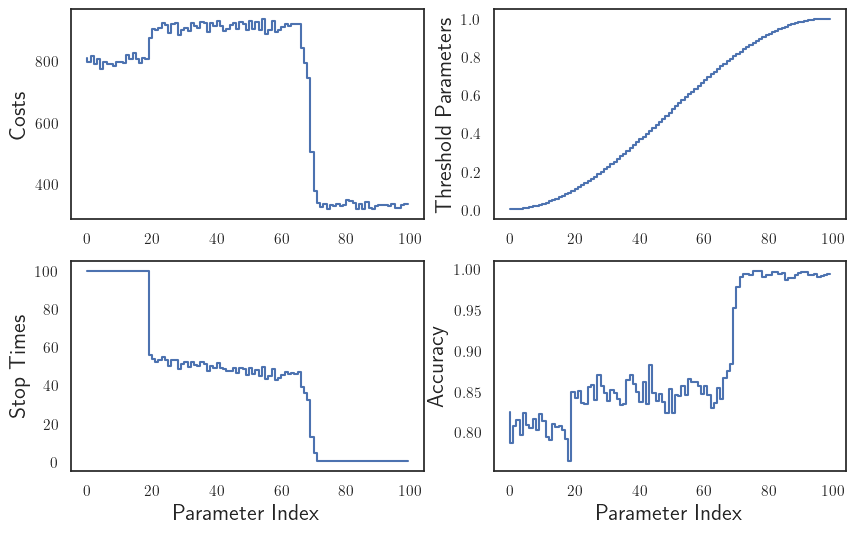

In [14]:
#### Plotting for the parameter sweep
import matplotlib
import seaborn as sns
matplotlib.rcParams.update({'text.usetex': True})
sns.set(style="white")
threshold_fn = lambda x: np.sin(x)**2
### autoregressively 
fig,axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].step(np.arange(grid_size), costs)
axs[0,0].set_ylabel("Costs", fontsize=16)

axs[0,1].step(np.arange(grid_size),threshold_fn(parameters))
axs[0,1].set_ylabel("Threshold Parameters", fontsize=16)
# axs[0,1].step(time_range, np.ones(len(time_range))*states[0,0], label='Parameters')


axs[1,0].step(np.arange(grid_size), stop_times.mean(1))
axs[1,0].set_ylabel("Stop Times", fontsize=16)

axs[1,1].step(np.arange(grid_size), (actions[:,:,-1]==states[:,:]).mean(axis=1))
axs[1,1].set_ylabel("Accuracy", fontsize=16)
axs[1,1].set_xlabel("Parameter Index", fontsize=16)

axs[1,0].set_xlabel("Parameter Index", fontsize=16)
plt.savefig("plots/parameter_sweep.pgf", bbox_inches='tight')
plt.show()  # Display the plots